In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import math
import tqdm
import os

import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.python.client import device_lib
import pathlib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17449237244142373050,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4928503808
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5698117902985286151
 physical_device_desc: "device: 0, name: GeForce GTX TITAN, pci bus id: 0000:01:00.0, compute capability: 3.5"]

In [41]:
data_dir = "../training_data/facesTrainingImages"
data_dir = pathlib.Path(data_dir)
batch_size = 10
img_height = 187
img_width = 250

In [42]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(  
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 59 files belonging to 5 classes.
Using 48 files for training.


In [43]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 59 files belonging to 5 classes.
Using 11 files for validation.


In [44]:
class_names = train_ds.class_names
print(class_names)

['dark', 'light', 'medium', 'veryDark', 'veryLight']


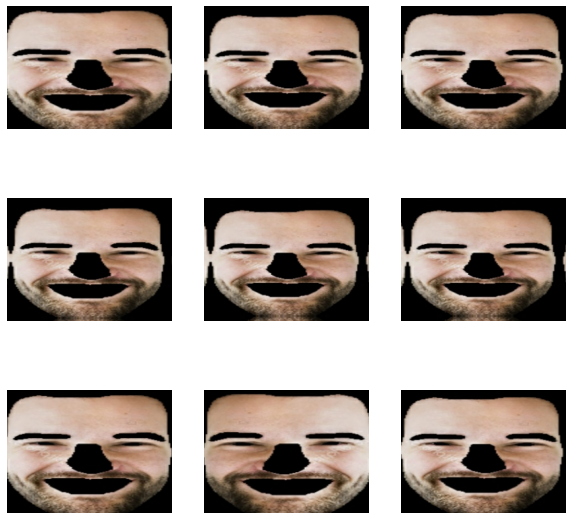

In [45]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [46]:
num_classes = len(class_names)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 187, 250, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 187, 250, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 187, 250, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 93, 125, 32)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 93, 125, 32)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 372000)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)               

In [48]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
5/5 [==============================] - 1s 63ms/step - loss: 7.5377 - accuracy: 0.3125 - val_loss: 10.4443 - val_accuracy: 0.0909
Epoch 2/15
5/5 [==============================] - 0s 32ms/step - loss: 4.4114 - accuracy: 0.2917 - val_loss: 2.2518 - val_accuracy: 0.0909
Epoch 3/15
5/5 [==============================] - 0s 33ms/step - loss: 1.3264 - accuracy: 0.4583 - val_loss: 1.2565 - val_accuracy: 0.1818
Epoch 4/15
5/5 [==============================] - 0s 32ms/step - loss: 1.2326 - accuracy: 0.3750 - val_loss: 1.6691 - val_accuracy: 0.0909
Epoch 5/15
5/5 [==============================] - 0s 33ms/step - loss: 1.1245 - accuracy: 0.5625 - val_loss: 1.4676 - val_accuracy: 0.2727
Epoch 6/15
5/5 [==============================] - 0s 33ms/step - loss: 1.0319 - accuracy: 0.7083 - val_loss: 1.4451 - val_accuracy: 0.2727
Epoch 7/15
5/5 [==============================] - 0s 33ms/step - loss: 0.8160 - accuracy: 0.7083 - val_loss: 1.5365 - val_accuracy: 0.1818
Epoch 8/15
5/5 [==========

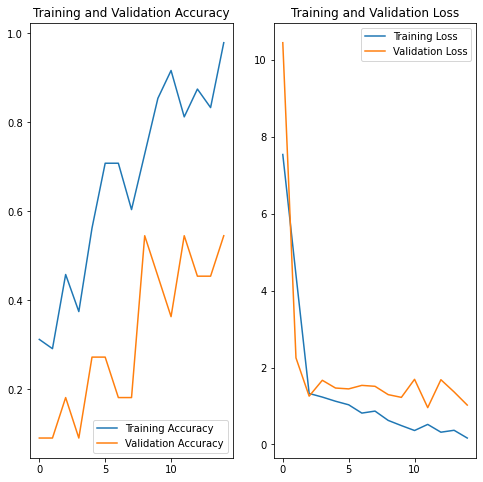

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
#model.save('faces_model_improved.h5', include_optimizer=False)

This image most likely belongs to medium with a 57.04 percent confidence.


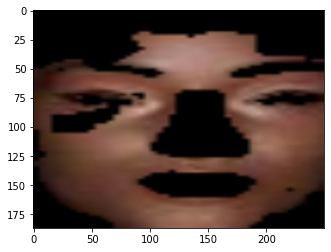

In [65]:
#test the model
imgagePath = r"../test_data/facesTestImagesProcessed/image-6.jpg"
img = keras.preprocessing.image.load_img(
    imgagePath, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)